In [1]:
import numpy as np
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from scipy.stats import loguniform

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8, 6))

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

Binary classification with SGDRegressor on MNIST data

In [3]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

We'll use a sigmoid function for the loss calculation here, so feature matrix should be scaled from 0 to 1.

In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(f'Mean of the features: {np.mean(X)}')
print(f'Std.deviation: {np.std(X)}')
print(f'Minimum value: {np.min(X)}')
print(f'Maximum value: {np.max(X)}')

Mean of the features: 0.13092720382627604
Std.deviation: 0.3084510570135976
Minimum value: 0.0
Maximum value: 1.0


In [6]:
target_names = np.unique(y)
print(f'Number of samples: {X.shape[0]}, type: {X.dtype}')
print(f'NUmber of features: {X.shape[1]}')
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Number of samples: 70000, type: float64
NUmber of features: 784
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

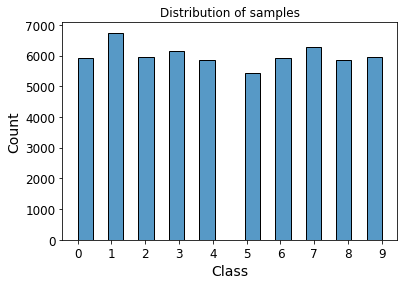

In [8]:
plt.figure()
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

In [9]:
#initialize new variable names with all 0
y_train_0 = np.zeros(y_train.shape[0])
y_test_0 = np.zeros(y_test.shape[0])

#find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


Dummy (Baseline) classifier

In [10]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])

base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print(f'Training accuracy: {base_clf.score(X_train, y_train_0):.4f}')
print(f'Testing accuracy: {base_clf.score(X_test, y_test_0):.4f}')

Training accuracy: 0.9013
Testing accuracy: 0.9020


Reason is obvious.  The model would've predicted 54077 samples correctly just by output 0 for all nput samples, Therefore, the accuracy will be 54077/60000 = 90.12%

LogisticRegression model

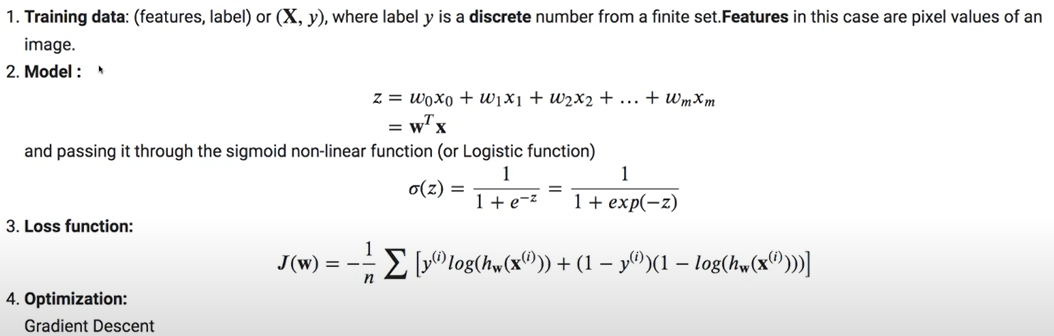

Training without Regularization

In [11]:
bin_sgd_clf = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)
Loss = []
iterations = 100
for i in range(iterations):
  bin_sgd_clf.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf.predict_proba(X_train)
  Loss.append(log_loss(y_train_0, y_pred))

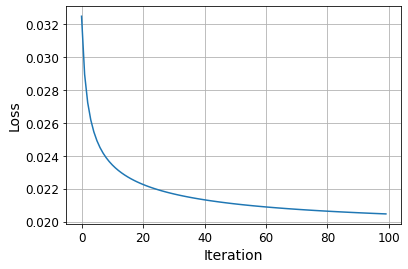

In [12]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

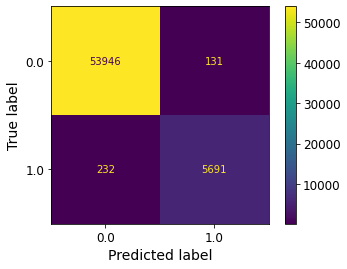

In [13]:
y_hat_train_0 = bin_sgd_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [14]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
fp = cf_matrix[0, 1]
tp = cf_matrix[1, 1]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tn + tp) / (tp + fp + tn + fn)
print(f"Precision: {precision}, Recall: {recall}, Acccuracy: {accuracy}")

Precision: 0.9774991411885949, Recall: 0.9608306601384433, Acccuracy: 0.99395


In [15]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



Now, let's see how much generalization can be achieved by cross-validation

In [16]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=100, warm_start=False, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

cv_bin_clf = cross_validate(estimator, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.41442037, 1.40808463, 1.39109921, 1.52932   , 1.26329732]),
 'score_time': array([0.04810739, 0.04425716, 0.0399878 , 0.03958154, 0.04071116]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

In [17]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
weights.shape, bias

((1, 784), array([-4.89282893]))

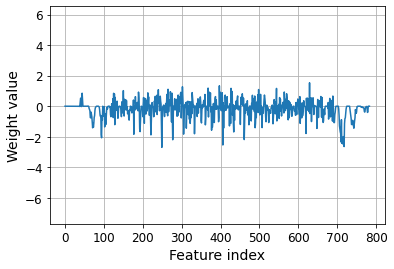

In [18]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

Training with regularization

In [19]:
bin_sgd_clf_l2 = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0.001, learning_rate='constant', random_state=1729)
Loss = []
iterations = 100
for i in range(iterations):
  bin_sgd_clf_l2.fit(X_train, y_train_0)
  y_pred = bin_sgd_clf_l2.predict_proba(X_train)
  Loss.append(log_loss(y_train_0, y_pred))

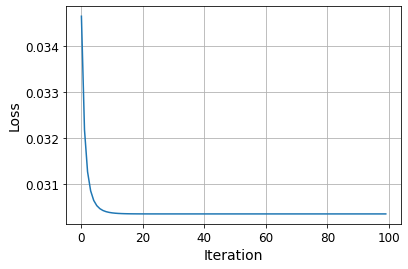

In [20]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

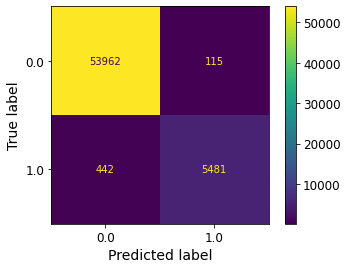

In [21]:
y_hat_train_0 = bin_sgd_clf_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [22]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



In [23]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
weights.shape, bias

((1, 784), array([-4.43002876]))

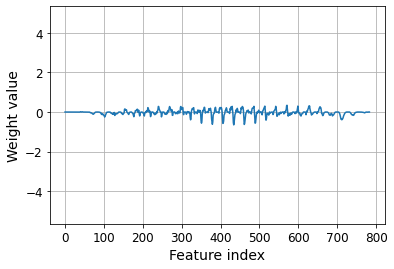

In [24]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

Hyper-parameter tuning

In [25]:
from scipy.sparse.construct import random
lr_grid = loguniform(1e-2, 1e-1)
print(lr_grid.rvs(3, random_state=42))

[0.02368864 0.0892718  0.05395031]


In [26]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

scores = RandomizedSearchCV(estimator, param_distributions={'eta0': lr_grid}, cv=5, scoring=['precision', 'recall', 'f1'], n_iter=5, refit='f1')

scores.fit(X_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa68b2aacd0>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [27]:
scores.cv_results_

{'mean_fit_time': array([0.37316937, 0.34095578, 0.33374186, 0.33370042, 0.33658581]),
 'mean_score_time': array([0.0537991 , 0.04556656, 0.04600458, 0.04563408, 0.05127363]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                    0.05395030966670228, 0.039687933304443715,
                    0.01432249371823025],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.02368863950364078},
  {'eta0': 0.08927180304353625},
  {'eta0': 0.05395030966670228},
  {'eta0': 0.039687933304443715},
  {'eta0': 0.01432249371823025}],
 'rank_test_f1': array([2, 5, 4, 3, 1], dtype=int32),
 'rank_test_precision': array([2, 5

In [28]:
scores.best_estimator_

SGDClassifier(alpha=0, eta0=0.01432249371823025, learning_rate='constant',
              loss='log', max_iter=1, random_state=1729, warm_start=True)

In [29]:
y_hat_train_best_0 = scores.best_estimator_.predict(X_train)

In [30]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000

